*Note*: this notebook must be run on the Planetary Computer Hub, or with the `PC_SDK_SUBSCRIPTION_KEY` environment variable set.

This notebook downloads all Sentinel 1 RTC data over a bounding box, then computes the fraction of observations at each pixel that have a VV or VH value that is greater than some cutoff threshold (we choose 0.3). Over water, pixels where this fraction is high likely belong to some stationary object -- either an offshore wind turbine, drilling rig, etc.

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import rasterio
import rasterio.features
import pystac_client
import planetary_computer as pc
import stackstac
import rtree
import fiona
import fiona.transform
import shapely.geometry
from shapely.geometry import box

from IPython.display import Image

In [2]:
bbox = [5.7458, 53.7594, 7.1686, 54.1994]  # off the north coast of Germany

catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1"
)
search = catalog.search(
    collections=["sentinel-1-rtc"], bbox=bbox, datetime="2022-07-19/2022-08-19"
)
items = search.item_collection()
print(f"Found {len(items)} items")
item = items[0]

Found 20 items


In [3]:
Image(url=item.assets["rendered_preview"].href)

In [4]:
ds = stackstac.stack(
    pc.sign(items), bounds_latlon=bbox, epsg=item.properties['proj:epsg'], resolution=10
)

In [5]:
img = ds[0,0].values

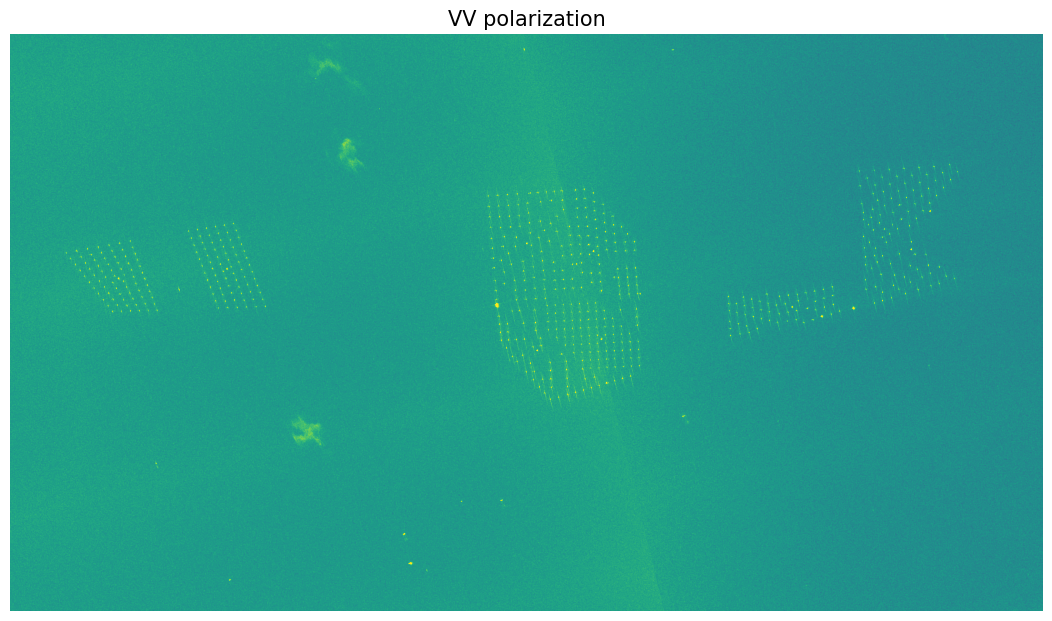

In [6]:
plt.figure(figsize=(13.5,7.5))
plt.imshow(np.log(img), vmax=-3)
plt.title("VV polarization", fontsize=15)
plt.axis("off")
plt.show()
plt.close()

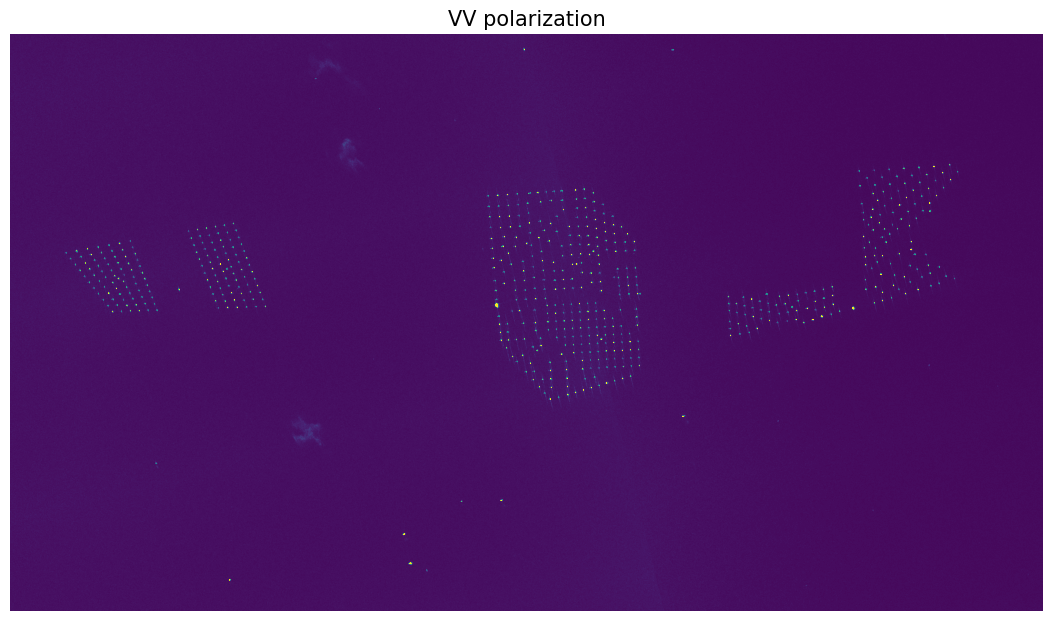

In [7]:
plt.figure(figsize=(13.5,7.5))
plt.imshow(img, vmax=0.1)
plt.title("VV polarization", fontsize=15)
plt.axis("off")
plt.show()
plt.close()

In [8]:
mask = ds > 0.3
mask_nan = ds.notnull()

In [9]:
vals = (mask & mask_nan).sum(axis=(0,1), dtype=float) / mask_nan.sum(axis=(0,1), dtype=float)

In [10]:
%%time
vals = vals.compute()

CPU times: user 2min 30s, sys: 17.2 s, total: 2min 47s
Wall time: 2min 5s


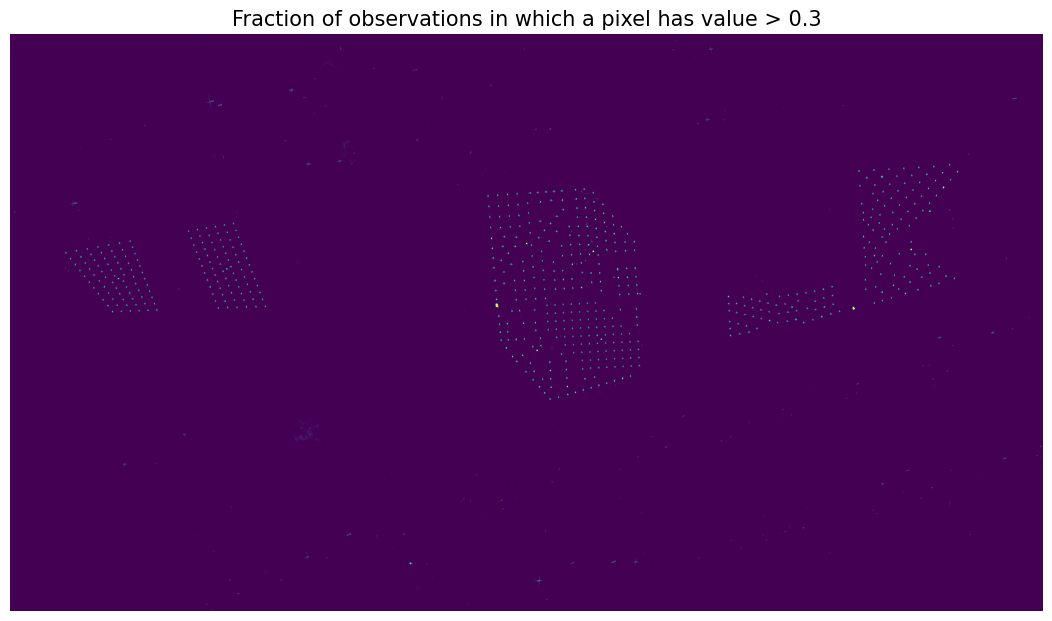

In [11]:
plt.figure(figsize=(13.5,7.5))
plt.imshow(vals, vmin=0, vmax=0.3)
plt.title("Fraction of observations in which a pixel has value > 0.3", fontsize=15)
plt.axis("off")

plt.show()
plt.close()

In [12]:
height, width = vals.shape

In [13]:
profile = {
    "driver": "GTiff",
    "transform": ds.transform,
    "height": height,
    "width": width,
    "count": 1,
    "dtype": "float32",
    "nodata": None,
    "crs": ds.crs,
    "blockxsize": 512,
    "blockysize": 512,
    "tiled": True,
    "compress": "lzw",
    "predictor": 2,
    "interleave": "band"
}

with rasterio.open("output.tif", "w", **profile) as f:
    f.write(vals.astype(np.float32), 1)

In [14]:
profile = {
    "driver": "GTiff",
    "transform": ds.transform,
    "height": height,
    "width": width,
    "count": 1,
    "dtype": "uint8",
    "nodata": None,
    "crs": ds.crs,
    "blockxsize": 512,
    "blockysize": 512,
    "tiled": True,
    "compress": "lzw",
    "predictor": 2,
    "interleave": "band"
}

with rasterio.open("output_threshold.tif", "w", **profile) as f:
    f.write((vals>=0.3).astype(np.uint8), 1)

In [15]:
%%time

features = []
shapes = []
original_shapes = []
areas = []
idx = rtree.index.Index()
i = 0
num_thrown_away = 0
with rasterio.open("output_threshold.tif") as f:
    t_features = list(rasterio.features.dataset_features(f, with_nodata=True, geographic=True))
    for feature in t_features:
        geom = fiona.transform.transform_geom("epsg:4326", "epsg:3857", feature["geometry"])
        shape = shapely.geometry.shape(geom)
        area = shape.area
        if feature["properties"]["val"] == 1 and area > 500 and area < 30000:  # could include an area threshold here
            feature["properties"]["area"] = shape.area
            feature["properties"]["idx"] = i
            features.append(feature)
            areas.append(shape.area)
            shapes.append(shape)
            idx.insert(id=i, coordinates=shape.bounds)
            i += 1
        else:
            num_thrown_away += 1
print(f"Throwing away {num_thrown_away} polygons")

merges = set()
merge_sets = dict()
for i, src_shape in enumerate(shapes):
    if i not in merges:
        to_merge = set([i])
        for j in idx.nearest(src_shape.bounds, num_results=10):
            dst_shape = shapes[j]
            distance = src_shape.distance(dst_shape)
            if i !=j and distance < 100:
                to_merge.add(j)
                merges.add(j)
        if len(to_merge) > 1:
            merge_sets[i] = to_merge

new_features = []
new_shapes = []
for i, shape in enumerate(shapes):
    if i in merge_sets:        
        merge_shapes = [
            shapes[j]
            for j in merge_sets[i]
        ]
        new_shape = shapely.geometry.MultiPolygon(merge_shapes).convex_hull

        geom = shapely.geometry.mapping(new_shape)
        geom = fiona.transform.transform_geom("epsg:3857", "epsg:4326", geom)

        new_feature = features[i]
        new_feature["properties"]["area"] = new_shape.area
        new_feature["geometry"] = geom
        new_features.append(new_feature)
        new_shapes.append(new_shape)
    elif i in merges:
        pass
    else:
        new_features.append(features[i])
        new_shapes.append(shape)

schema = {
    "geometry": "Polygon",
    "properties": {
        "idx": "int",
        "val": "float",
        "filename": "str",
        "area": "float"
    }
}

Throwing away 100 polygons
CPU times: user 1.47 s, sys: 140 ms, total: 1.61 s
Wall time: 1.62 s


In [16]:
# insertings distances to each feature
# rebuilding (for reorder) idx rtree and create index dictionary
feature_dict = {}
idx = rtree.index.Index()

for feature in new_features:
    idx.insert(feature['properties']['idx'], feature['bbox'], obj=feature)
    feature_dict[feature['properties']['idx']] = feature
    
for feature in new_features:
    # insert ratios
    height = shape.bounds[3] - shape.bounds[1]
    width = shape.bounds[2] - shape.bounds[0]
    feature['height'] = height
    feature['width'] = width
    feature['ratio'] = height/width
    
    num_distances = 4
    nearest_indexes = list(idx.nearest(feature['bbox'], num_distances))
    current_index = feature['properties']['idx']
    nearest_indexes.remove(current_index)
    
    # loop thro indexes
    i = 1
    for index in nearest_indexes:
        # check distance between each index and input it within new_features
        box1 = box(feature_dict[current_index]['bbox'][0], feature_dict[current_index]['bbox'][1], 
                   feature_dict[current_index]['bbox'][2], feature_dict[current_index]['bbox'][3])
        box2 = box(feature_dict[index]['bbox'][0], feature_dict[index]['bbox'][1], 
                   feature_dict[index]['bbox'][2], feature_dict[index]['bbox'][3])
        feature['distance {0}'.format(i)] = box1.distance(box2)
        i += 1


with fiona.open("original.geojson", "w", driver="GeoJSON", crs="EPSG:4326", schema=schema) as f:
    for feature in new_features:
        f.write(feature)        

In [17]:
!pip install -U imbalanced-learn
import imblearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from imblearn.over_sampling import RandomOverSampler

  Using cached imbalanced_learn-0.10.1-py3-none-any.whl (226 kB)


In [32]:
features_list = []
labels_list = []

# manually tracked stationary objects
stationary_objects_idx = [69, 157, 181, 188, 264, 303, 311, 383, 449, 545, 566, 623]

for feature in new_features:
    features_list.append([feature['properties']['area'], feature['height'], feature['width'], feature['ratio'], 
                          feature['distance 1'], feature['distance 2'], feature['distance 3']])
    
    if feature['properties']['idx'] in stationary_objects_idx:
        labels_list.append(0)
    else:
        labels_list.append(1)
        
features_list = np.array(features_list)
labels_list = np.array(labels_list)

scaler = StandardScaler()
features_list = scaler.fit_transform(features_list)

over = RandomOverSampler()
features_list, labels_list = over.fit_resample(features_list, labels_list)

x_train, x_temp, y_train, y_temp = train_test_split(features_list, labels_list, test_size=0.4, random_state=0)
x_valid, x_test, y_valid, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=0)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=16, activation="relu"),
    tf.keras.layers.Dense(units=16, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
             loss=tf.keras.losses.BinaryCrossentropy(),
             metrics=['accuracy'])

model.fit(x_train, y_train, batch_size=24, epochs=40, validation_data=(x_valid, y_valid))

model.evaluate(x_test, y_test)

print("done")

Epoch 1/30
30/30 [==============================] - 0s 5ms/step - loss: 0.7575 - accuracy: 0.4708 - val_loss: 0.6471 - val_accuracy: 0.7051
Epoch 2/30
30/30 [==============================] - 0s 4ms/step - loss: 0.6057 - accuracy: 0.6842 - val_loss: 0.5569 - val_accuracy: 0.7222
Epoch 3/30
30/30 [==============================] - 0s 3ms/step - loss: 0.5378 - accuracy: 0.7098 - val_loss: 0.4973 - val_accuracy: 0.7265
Epoch 4/30
30/30 [==============================] - 0s 3ms/step - loss: 0.4957 - accuracy: 0.7340 - val_loss: 0.4571 - val_accuracy: 0.7650
Epoch 5/30
30/30 [==============================] - 0s 3ms/step - loss: 0.4655 - accuracy: 0.7653 - val_loss: 0.4263 - val_accuracy: 0.7863
Epoch 6/30
30/30 [==============================] - 0s 3ms/step - loss: 0.4415 - accuracy: 0.7909 - val_loss: 0.4019 - val_accuracy: 0.8162
Epoch 7/30
30/30 [==============================] - 0s 3ms/step - loss: 0.4241 - accuracy: 0.8065 - val_loss: 0.3820 - val_accuracy: 0.8462
Epoch 8/30
30/30 [==